In [1]:
import pandas as pd
import numpy as np

# --- HAPPINESS DATA ---
happiness = pd.read_csv(
    r"C:/Users/BARTU/OneDrive/Masaüstü/DSA210-Project/data/raw/happiness.csv",
    encoding="latin1"
)

happiness.columns = happiness.columns.str.strip()
happiness_long = happiness.copy()
happiness_long["Year"] = happiness_long["Year"].astype(int)

ilk_kolon = happiness_long.columns[0]
happiness_long = happiness_long.rename(columns={ilk_kolon: "country_name"})


# --- INFLATION DATA ---
path = r"C:/Users/BARTU/OneDrive/Masaüstü/DSA210-Project/data/raw/inflation.csv"

rows = []
with open(path, encoding="latin1") as f:
    header = f.readline().strip()
    cols = header.split(",")
    n_cols = len(cols)

    for line in f:
        parts = line.strip().split(",")
        if len(parts) < n_cols:
            parts += [""] * (n_cols - len(parts))
        elif len(parts) > n_cols:
            parts = parts[:n_cols]
        rows.append(parts)

inflation = pd.DataFrame(rows, columns=cols)
inflation.columns = inflation.columns.str.strip().str.replace('"', '')

id_cols = ["country_name", "indicator_name"]
year_cols = [c for c in inflation.columns if c.isdigit()]

inflation_long = inflation.melt(
    id_vars=id_cols,
    value_vars=year_cols,
    var_name="Year",
    value_name="Inflation"
)

inflation_long["Year"] = inflation_long["Year"].astype(int)
inflation_long = inflation_long.sort_values(by=["country_name", "Year"]).reset_index(drop=True)


# --- COUNTRY NAME CLEANING ---
def clean_country(x):
    return x.strip().replace('"', '')

happiness_long["country_name"] = happiness_long["country_name"].apply(clean_country)
inflation_long["country_name"] = inflation_long["country_name"].apply(clean_country)


# --- FINAL MERGE ---
final = pd.merge(
    happiness_long,
    inflation_long,
    on=["country_name", "Year"],
    how="inner"
)

final["Inflation"] = pd.to_numeric(final["Inflation"], errors="coerce")
final["Index"] = pd.to_numeric(final["Index"], errors="coerce")

final = final.dropna(subset=["Inflation", "Index"])

final.head()


,country_name,Year,Index,Rank,indicator_name,Inflation
0,Afghanistan,2013,4.040,143.0,Annual average inflation (consumer prices) rate,7.39
1,Afghanistan,2015,3.575,153.0,Annual average inflation (consumer prices) rate,-0.66
2,Afghanistan,2016,3.360,154.0,Annual average inflation (consumer prices) rate,4.38
3,Afghanistan,2017,3.794,141.0,Annual average inflation (consumer prices) rate,4.98
4,Afghanistan,2018,3.632,145.0,Annual average inflation (consumer prices) rate,0.63


In [2]:
final.shape


(1371, 6)

In [3]:
country_features = (
    final.groupby("country_name")[["Inflation", "Index"]]
        .agg(["mean", "std"])
)

country_features.columns = [f"{c}_{s}" for c, s in country_features.columns]
country_features = country_features.dropna()

country_features.head()


,Inflation_mean,Inflation_std,Index_mean,Index_std
country_name,,,,
Afghanistan,5.233,4.174630,3.09570,0.714409
Albania,2.560,1.758282,4.95890,0.320956
Algeria,5.430,2.559970,5.41030,0.437737
Angola,19.620,10.630710,4.21560,0.773886
Argentina,51.075,34.020068,6.19125,0.279618


In [4]:
econ_features = (
    final.groupby("country_name")["Inflation"]
         .agg(Inflation_mean="mean", Inflation_std="std")
         .dropna()
)

econ_features.head()


,Inflation_mean,Inflation_std
country_name,,
Afghanistan,5.233,4.174630
Albania,2.560,1.758282
Algeria,5.430,2.559970
Angola,19.620,10.630710
Argentina,51.075,34.020068


C:\Users\BARTU\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\BARTU\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\BARTU\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\BARTU\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

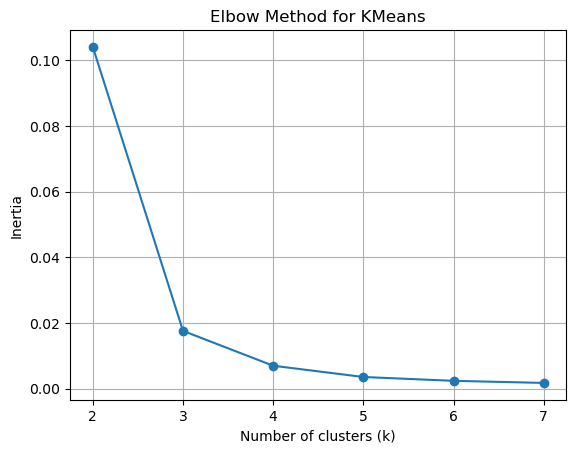

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# SADECE clustering feature'ları
X = econ_features[["Inflation_mean", "Inflation_std"]].to_numpy()

# scale
X_scaled = StandardScaler().fit_transform(X)

# elbow
inertias = []
K = range(2, 8)

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

# plot
plt.figure()
plt.plot(list(K), inertias, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for KMeans")
plt.grid(True)
plt.show()


In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

X = econ_features.values
X_scaled = StandardScaler().fit_transform(X)

k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
econ_features["cluster"] = kmeans.fit_predict(X_scaled)

econ_features["cluster"].value_counts()


C:\Users\BARTU\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


cluster
0    145
2      2
1      1
Name: count, dtype: int64

In [7]:
k = 2

kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
econ_features["cluster"] = kmeans.fit_predict(X_scaled)

econ_features["cluster"].value_counts()


C:\Users\BARTU\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


cluster
0    147
1      1
Name: count, dtype: int64

In [8]:
econ_features.sort_values("Inflation_mean", ascending=False).head(10)


,Inflation_mean,Inflation_std,cluster
country_name,,,
Venezuela,9062.550000,20702.203955,1
South Sudan,148.960000,128.844724,0
Zimbabwe,142.800000,187.933688,0
Argentina,51.075000,34.020068,0
Lebanon,47.266667,71.138562,0
Sudan,33.380000,18.842956,0
Iran,29.960000,14.561837,0
Yemen,24.077778,7.697691,0
Suriname,21.433333,29.608332,0


In [9]:
econ_features_filtered = econ_features[
    econ_features["Inflation_mean"] < 100
].copy()

econ_features_filtered.shape


(145, 3)

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

X = econ_features_filtered.values
X_scaled = StandardScaler().fit_transform(X)

k = 2
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
econ_features_filtered["cluster"] = kmeans.fit_predict(X_scaled)

econ_features_filtered["cluster"].value_counts()


C:\Users\BARTU\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


cluster
0    140
1      5
Name: count, dtype: int64

In [11]:
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

df = final.copy()

df["Inflation"] = pd.to_numeric(df["Inflation"], errors="coerce")
df["Index"] = pd.to_numeric(df["Index"], errors="coerce")

# 2) NaN at
df = df.dropna(subset=["Inflation", "Index", "Year"])

# 3) log1p için güvenli filtre: Inflation > -1 olmalı
df = df[df["Inflation"] > -0.999999]

# 4) outlier kırp
df = df[df["Inflation"] < 100]

# 5) log feature
df["Inflation_log"] = np.log1p(df["Inflation"])

# 6) inf varsa temizle
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["Inflation_log"])

# --- TIME SPLIT ---
train = df[df["Year"] <= 2017]
test  = df[df["Year"] > 2017]

# --- OLS ---
X_train = sm.add_constant(train[["Inflation_log"]])
y_train = train["Index"]
model = sm.OLS(y_train, X_train).fit()

X_test = sm.add_constant(test[["Inflation_log"]])
y_test = test["Index"]
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print("n_train:", len(train), "n_test:", len(test))
print("RMSE:", round(rmse, 3))
print("MAE :", round(mae, 3))
print("R²  :", round(r2, 3))


n_train: 540 n_test: 781
RMSE: 1.089
MAE : 0.892
R²  : 0.053


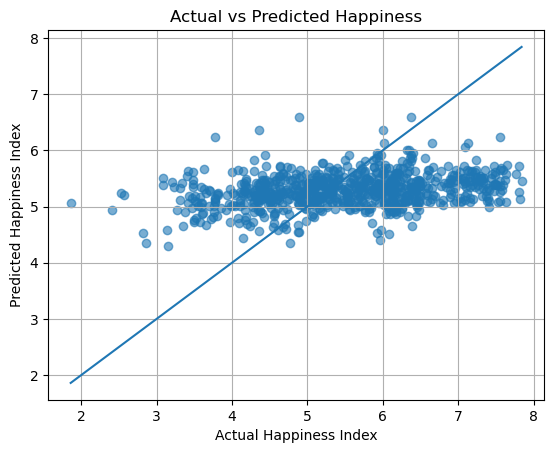

In [12]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()]
)
plt.xlabel("Actual Happiness Index")
plt.ylabel("Predicted Happiness Index")
plt.title("Actual vs Predicted Happiness")
plt.grid(True)
plt.show()


# The Effect of Inflation on Happiness

## 1. Introduction

Happiness is important in people’s lives and shows how happy they are with their living conditions. Inflation means prices go up over time. When inflation is high, people may find it hard to buy basic things. Because of this, inflation can affect people’s happiness.

This study aims to determine if inflation impacts happiness levels in different countries.

## 2. Data Description

This study uses two datasets. One dataset contains happiness scores from various countries over several years. The other dataset provides yearly inflation rates for the same countries.

The datasets were merged using country names and years. After the merge, each row represents one country for a specific year.

The main variables in this study are:

- **Happiness Index**: represents the average happiness level  
- **Inflation**: the yearly inflation rate  

## 3. Data Preparation

Before the analysis, the data was cleaned. Country names were corrected to eliminate errors. Happiness and inflation values were converted to numeric form. Rows with missing values were removed.

Extremely high inflation values were also excluded, as they could skew the results. Inflation was adjusted using a logarithmic method to minimize large differences between countries.

The data was split into two parts:

- **Training data**: years before 2018  
- **Test data**: years after 2017  

This separation ensured that future information was not used in the model.

## 4. Methodology

### 4.1 Regression Analysis

A linear regression model studied the relationship between inflation and happiness. Happiness served as the dependent variable, while inflation was the independent variable.

The model was trained with the training data and then tested with the test data.

### 4.2 Clustering Analysis

Clustering was used as an additional method. Countries were grouped based on their average inflation and changes in inflation. This method reveals different inflation patterns but does not establish cause and effect.

## 5. Results

### 5.1 Regression Results

The regression model produced the following results on the test data:

- **RMSE**: 1.089  
- **MAE**: 0.892  
- **R²**: 0.053  

The graph comparing actual and predicted values shows that the model usually predicts values close to the average happiness score. Inflation does not account for significant differences in happiness effectively.

### 5.2 Interpretation

The low R² value indicates that inflation explains only a small portion of happiness. This suggests that other factors play a more important role.

## 6. Discussion

The results indicate that inflation alone cannot account for happiness differences between countries. Countries with similar inflation rates can still have vastly different happiness levels.

This demonstrates that happiness relies on more than just economic factors.

## 7. Conclusion

This study explored the relationship between inflation and happiness using data from multiple countries. The results reveal that inflation has a weak effect on happiness.

Overall, inflation alone is not a reliable indicator of people's happiness.

## 8. Limitations and Future Work

This study has some limitations. Only inflation was included in the model, leaving out other significant factors. Additionally, differences between countries were not fully accounted for.

Future research can incorporate more variables and employ better models to clarify the understanding of happiness.
riables and employ better models to clarify the understanding of happiness.